In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import random
import re
from tqdm import tqdm
import torch
#from transformers import LlamaTokenizer, LlamaForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Qwen2ForCausalLM, Qwen2Tokenizer

import os
import pickle
import matplotlib.pyplot as plt

#os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
#os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"

import random
import json
import seaborn as sbn

STORAGE_DIR = "cache/"
device = 'cuda:4'
print(torch.cuda.is_available())

True


In [3]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-14B",
                                      #   cache_dir="/mnt/hdd_drive/huggingface/hub/",
                                         torch_dtype=torch.float16
                                       #  token=MY_TOKEN
                                        )
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-14B",
                                     #       cache_dir="/mnt/hdd_drive/huggingface/hub/"
                                     #    token=MY_TOKEN
                                        )
model = model.to(device)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
LAYER_NUM = model.config.num_hidden_layers
HEAD_NUM = model.config.num_attention_heads

HEAD_SPAN = model.config.hidden_size // model.config.num_attention_heads

# !! CHANGE the following line if you use this code with models implementing Grouped query attention
QUERIES_PER_KEY = model.config.num_attention_heads // model.config.num_key_value_heads

print(LAYER_NUM, HEAD_NUM, HEAD_SPAN, QUERIES_PER_KEY)

OPTIONS = ["A", "B", "C", "D"] #, "E", "F", "G", "H", "I", "J"]
LETTER_TOKENS = np.array([tokenizer(x)['input_ids'][-1] for x in OPTIONS])
print(LETTER_TOKENS)

#model = model.to(device)
prunned_head = torch.nn.Parameter(model.lm_head.weight[np.hstack([LETTER_TOKENS,])], requires_grad=False)

40 40 128 5
[32 33 34 35]


In [5]:
model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-39): 40 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (up_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (down_proj): Linear(in_features=17408, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): 

In [6]:
from collections import OrderedDict 

class NewModel(torch.nn.Module):
    def __init__(self, model, *args):
        super().__init__(*args)
        self.selected_out = OrderedDict()

        self.pretrained = model.model
        self.fhooks = []

        for i in range(LAYER_NUM):
            self.fhooks.append(self.pretrained.layers[i].self_attn.q_proj
                .register_forward_hook(self.forward_hook("query_vec_" + str(i))))
            self.fhooks.append(self.pretrained.layers[i].self_attn.k_proj
                .register_forward_hook(self.forward_hook("key_vec_" + str(i))))
        
    
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output.cpu()
        return hook

    def forward(self, x):        
        out = self.pretrained(**x.to(device))
        return out, self.selected_out
    
newmodel = NewModel(model)

In [7]:
def permute_options(options, label, seed):
    """
    A pseudo-random shuffle of the answer <<options>> that also returns new correct answer
        parameters:
                options --- list of options
                label   --- correct answer
                seed    --- random seed
                
    Options 'E' and 'F' are special and must remain at their places
    """
    aaa = np.arange(len(options))
    np.random.seed(seed)
    np.random.shuffle(aaa)
    
    new_label = chr(ord('A') + aaa[ord(label) - ord('A')])
    new_options = {}
    for option in range(len(options)): 
        new_options[aaa[option]] = options[option]
   
#    new_options['E'] = options['E']  
 #   new_options['F'] = options['F']

    return dict(sorted(new_options.items())), new_label

def format_prompt(elem):
    text = ""
    if "context" in elem.keys():
        text += "Context: " + elem["context"] + "\n"
    text += "Question: " + elem["question"] + "\nOptions:\n"
    for option in elem['choices'].keys():
        text += option + ". " + str(elem['choices'][option]) + "\n"   
    text += "Answer: " + elem["answer"] + "\n"
    return text
    
def angular_dist(vec_a, vec_b):
    # Without normalization it works much faster and yields better results for some unknown reason
    return torch.sum(vec_a * vec_b) #/ (vec_a.norm(p=2) * vec_b.norm(p=2))

In [8]:
from datasets import load_dataset
df = load_dataset("krammnic/hle-multichoice")

In [9]:
from copy import deepcopy

def split_options(inp):
    inp = inp.replace('  ', ' ')
    parts = inp.split("Answer Choices:\n")
    if len(parts) != 2:
        print("WTF: ", inp)

    question = parts[0]
    residue = "\n" + parts[1]
    options_dict = {}
    char = 'A'
    while True:
        pos = residue.find("\n" + char + ". ")
        if pos == -1:
            break

        next_char = chr(ord(char) + 1)
        pos_n = residue.find("\n" + next_char + ". ")

        if pos_n > 0:
            options_dict[char] = deepcopy(residue[4:pos_n])
        else:
            options_dict[char] = deepcopy(residue[4:])
        residue = residue[pos_n:]
        char = next_char

    return question, options_dict

def select_4_options(inp, correct_option):
    question, options_total = split_options(inp)

    incorrect_keys = np.random.choice(list(options_total.keys()), 4, replace=False).tolist()
    if correct_option not in incorrect_keys:
        incorrect_keys = incorrect_keys[:3] + [correct_option]

    np.random.shuffle(incorrect_keys)
    new_correct = 'A'
    for i in range(4):
        if incorrect_keys[i] == correct_option:
            new_correct = chr(ord('A') + i)
            break

    option_lst = []
    for K in incorrect_keys:
        option_lst.append(options_total[K])

    return question, option_lst, new_correct

def process_open_end(entry):
    question = entry['question']
    option_lst = [entry['incorrect_answer_1'], entry['incorrect_answer_2'], entry['incorrect_answer_3'], entry['correct_answer']]

    np.random.shuffle(option_lst)

    new_correct = 'A'
    for i in range(4):
        if option_lst[i] == entry['correct_answer']:
            new_correct = chr(ord('A') + i)
            break
    return question, option_lst, new_correct

In [10]:
def process_questions():
    questions = []
    option_lists = []
    answers = []
    for i in range(len(df['train'])):
        if df['train'][i]['answer_type'] == 'exactMatch':
            outp = process_open_end(df['train'][i])
        else:
            outp = select_4_options(df['train'][i]['question'], df['train'][i]['correct_answer'])

        if None in outp[1]:
            print(i, "skipped due to NaN")
            continue

        questions.append(outp[0])
        option_lists.append(outp[1])
        answers.append(outp[2])

    df_clean = pd.DataFrame.from_dict({'question' : questions, 'options' : option_lists, 'answer' : answers})
    return df_clean

df_clean = process_questions()
df = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)

1303 skipped due to NaN
2094 skipped due to NaN


In [11]:
df_clean

,question,options,answer
0,Which condition of Arrhenius's sixth impossibi...,"[Egalitarian Dominance, Weak Non-Sadism, Non-E...",B
1,"The concept of logical ""depth"" mentioned in _T...","[yeya, yeno, yeye, yeyo]",D
2,Compute the reduced 12-th dimensional Spin bor...,"[Z+Z+Z, Z+Z+Z+Z+Z, Z, Z+Z+Z+Z+Z+Z]",B
3,What is the largest order of a non-cyclic tors...,"[18, 6, 24, 12]",A
4,Let $\mathfrak{g}$ be the 6-dimensional real L...,"[1 + 2x + 4x^2 + 6x^3 + 5x^4 + 3x^5 + x^6, 1 +...",D
...,...,...,...
2151,"In 2018, Thomas Carrell discovered a set of re...","[11, 8, 13, 15]",A
2152,Let $ u_r(n) $ denote the minimal order of the...,"[{2, 2, 4, 2, 6, 4, 8, 4, 12, 6}, {2, 2, 4, 2,...",C
2153,Chesterton's character committed misdeeds for ...,"[Cairo, Jerusalem, Bethlehem, Bethlehem, Cana,...",C
2154,By finding formaldehyde's homologs with the ma...,"[1, 0, -4/3, -1]",C


In [25]:
def do_calc_dev(data, samples_range=range(10000), permute=False, return_logits=False, num=0):
    """
    Parameters:
        data      ------- self-explanatory
        prompt      ----- Here go examples in case of the Few-Shot prompting. For Zero-shot leave it empty.
        samples_range --- Container with numbers of samples to be considered 
        permute     ----- Specifies if a permutation of answer options is required
        return_logits  -- Set True if you need not only the predicted labels, but also row similarities and baseline logits
                                    for every possible option A-F
    
    """
    true_labels = []
    predicted_labels, predicted_raw = [], []
    next_token_labels, logits_options = [], []

    for LAYER in range(LAYER_NUM):
        predicted_labels.append([])
        predicted_raw.append([])

        for HEAD in range(HEAD_NUM):
            predicted_labels[LAYER].append([])
            predicted_raw[LAYER].append([])

    for EXMPL in tqdm(samples_range):
        sample = data.iloc[EXMPL]
        """
        Assembling the prompt from different parts: Examples (if any) + Context + Question + Options + Finisher
        """
        text = "Think logically and select the correct answer to the following question.\nQuestion:" + sample["question"]
        encodinds_context_q = tokenizer(text, return_tensors="pt")
            
        num_q = encodinds_context_q["input_ids"].shape[-1] - 1
        encodings_answ, options_answ = [], []
        
        """ 
        For some experiments we need to permute answer options
        """
        options_raw, answer_raw = sample['options'], sample['answer']
        
        if permute:
            options_raw, answer_raw = permute_options(options_raw, answer_raw, EXMPL)
        
        for option in OPTIONS[:len(sample['options'])]:
            options_raw[ord(option) - ord('A')] = str(options_raw[ord(option) - ord('A')])            
            text += option + ". " + options_raw[ord(option) - ord('A')] + "\n"
        
            encodings_answ.append(tokenizer(option + ". " + options_raw[ord(option) - ord('A')] + "\n", return_tensors="pt"))
        
            if len(options_answ) == 0:
                options_answ.append(int(num_q + encodings_answ[-1]["input_ids"].shape[-1]))
            else:
                options_answ.append(int(options_answ[-1] + encodings_answ[-1]["input_ids"].shape[-1]))

        text += "You can think a little before giving your final answer.\n"
        inputs = tokenizer(text, return_tensors="pt")
        
        """
        If promt format was changed use this to debug:
        
        print(inputs)
        for i in range(len(options_answ)):
            print(inputs["input_ids"][..., options_answ[i]]) # <<<<<< This must be aligned
        print("\n\n", inputs["input_ids"][..., -1])
        """
        with torch.no_grad():
            results = model.generate(**inputs.to(device), max_new_tokens=600, pad_token_id=tokenizer.eos_token_id).cpu()
            text_ext = tokenizer.batch_decode(results[:, inputs["input_ids"].shape[-1] :], skip_special_tokens=True)[0]

      #  print(text_ext)
        text_2 = text_ext.split("Answer:")[0] + "\nNow provide your final answer. Output one letter only.\nAnswer:"

        inputs2 = tokenizer(text_2, return_tensors="pt")
     #   print(text_2)
        inputs2["input_ids"] = torch.cat([inputs["input_ids"].to(device), inputs2["input_ids"][:, 1:].to(device)], -1)
        inputs2["attention_mask"] = torch.cat([inputs["attention_mask"].to(device), inputs2["attention_mask"][:, 1:].to(device)], -1)
        with torch.no_grad():   
            outputs = newmodel(inputs2)

        true_labels.append(answer_raw)
        for LAYER in range(LAYER_NUM):
            for HEAD in range(HEAD_NUM):
                predicts = np.zeros(len(options_answ))
                for i in range(len(options_answ)):
                    predicts[i] = angular_dist(outputs[1]["query_vec_" + str(LAYER)][0][-1][HEAD * HEAD_SPAN:(HEAD + 1) * HEAD_SPAN], 
                                                                                    outputs[1]["key_vec_" + str(LAYER)][0][options_answ[i]][(HEAD // QUERIES_PER_KEY) * HEAD_SPAN:((HEAD // QUERIES_PER_KEY) + 1) * HEAD_SPAN])

                predicted_labels[LAYER][HEAD].append(chr(np.argmax(predicts) + ord('A')))
                if return_logits:
                    predicted_raw[LAYER][HEAD].append(predicts)

        """
        This part is for the baseline prediction --- that is an A-F letter which is the most probable next token after prompt.
        """
        logits = (prunned_head @ outputs[0].last_hidden_state[0][-1]).cpu()
        logits_full = logits.squeeze(0)
        logits_reduced = logits_full.numpy()
        
        if return_logits:
            logits_options.append(logits_reduced)
        
        next_token_labels.append(chr(ord('A') + np.argmax(logits_reduced)))
        """
        end of baseline part
        """

    for LAYER in range(LAYER_NUM):
        predicted_labels[LAYER] = np.array(predicted_labels[LAYER])
        if return_logits:
            predicted_raw[LAYER] = np.array(predicted_raw[LAYER])

    predicted_labels = np.stack(predicted_labels)
    
    if return_logits:
        predicted_raw = np.stack(predicted_raw)
        logits_options = np.stack(logits_options)

        return true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options)
    else:
        return true_labels, predicted_labels, next_token_labels

In [14]:
def get_train_matrix(true_labels, qk_predicts):
    mn = np.zeros((LAYER_NUM,HEAD_NUM))
    for i in range(LAYER_NUM):
        for j in range(HEAD_NUM):
            mn[i][j] = np.mean(qk_predicts[i][j] == true_labels)
    return (np.argmax(mn.flatten()) // HEAD_NUM, np.argmax(mn.flatten()) % HEAD_NUM), mn

def PermutationAccuracy(target1, predict1, target2, predict2):
    return np.mean((np.array(target1) == predict1) *  (np.array(target2) == predict2))

In [ ]:
############################# ALTERNATE VERSION #########################################
true_labels1, qk_predicts1, baseline_predicts1 = do_calc_dev(df, range(500))
true_labels2, qk_predicts2, baseline_predicts2 = do_calc_dev(df, range(500), permute=True)

best_head1, mn1 = get_train_matrix(true_labels1, qk_predicts1)
print("Baseline:", np.mean(np.array(true_labels1) == baseline_predicts1))
print("QK:", mn1.max(), best_head1)
sbn.heatmap(mn1)
best_head2, mn2 = get_train_matrix(true_labels2, qk_predicts2)
print("Baseline:", np.mean(np.array(true_labels2) == baseline_predicts2))
print("QK:", mn2.max(), best_head2)
############################# ALTERNATE VERSION #########################################

  0%|                                                                                                                                                                                                                                | 0/500 [00:00<?, ?it/s]

In [15]:
true_labels1, qk_predicts1, baseline_predicts1 = do_calc_dev(df, range(500))
true_labels2, qk_predicts2, baseline_predicts2 = do_calc_dev(df, range(500), permute=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:23:45<00:00, 17.25s/it]


Baseline: 0.336
QK: 0.354 (np.int64(31), np.int64(20))


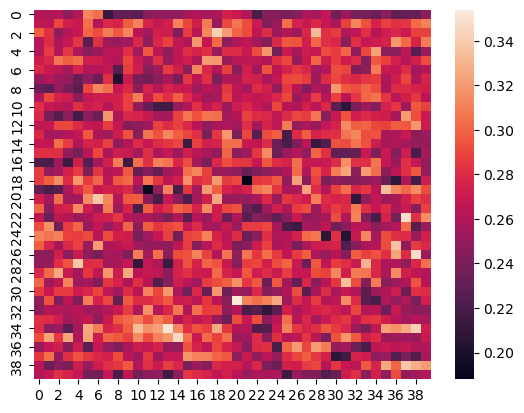

In [16]:
best_head1, mn1 = get_train_matrix(true_labels1, qk_predicts1)
print("Baseline:", np.mean(np.array(true_labels1) == baseline_predicts1))
print("QK:", mn1.max(), best_head1)
sbn.heatmap(mn1)
plt.savefig("pictures/qwen3_qwen14b_hle4_cot.png")

Baseline: 0.36
QK: 0.35 (np.int64(28), np.int64(37))


<Axes: >

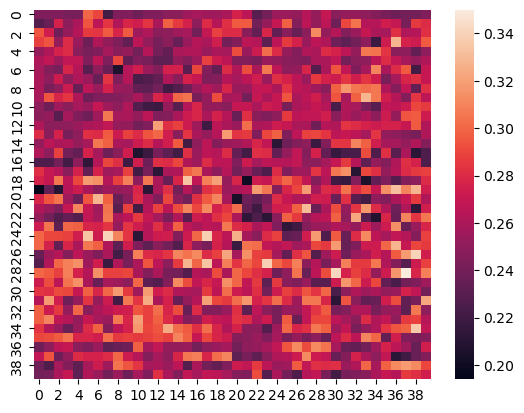

In [17]:
best_head2, mn2 = get_train_matrix(true_labels2, qk_predicts2)
print("Baseline:", np.mean(np.array(true_labels2) == baseline_predicts2))
print("QK:", mn2.max(), best_head2)
sbn.heatmap(mn2)

In [18]:
results_to_report = {
    'train_1' : {'true_labels' : true_labels1, 'qk_predicts' : qk_predicts1, 'baseline_predicts' : baseline_predicts1},
    'train_2' : {'true_labels' : true_labels2, 'qk_predicts' : qk_predicts2, 'baseline_predicts' : baseline_predicts2}
}

with open("cache/qwen3_qwen14B_HLE4_CoT_train.pkl", "wb") as file:
    pickle.dump(results_to_report, file)

In [19]:
def do_calc_eval(data, head=(0,0), prompt='', samples_range=range(10000), permute=False, num=[0,]):
    """
    Parameters:
        data      ------- self-explanatory
        head          --- Pair (#LAYER, #HEAD),
        prompt      ----- Here go examples in case of the Few-Shot prompting. For Zero-shot leave it empty.
        samples_range --- Container with numbers of samples to be considered 
        permute     ----- Specifies if a permutation of answer options is required    
    """
    true_labels = []
    predicted_labels = []
    next_token_labels = []
    
    LAYER, HEAD = head
    for EXMPL in tqdm(samples_range):
        sample = data.iloc[EXMPL]
        """
        Assembling the prompt from different parts: Examples (if any) + Context + Question + Options + Finisher
        """
        text = "Think logically and select the correct answer to the following question.\nQuestion:" + sample["question"]
        encodinds_context_q = tokenizer(text, return_tensors="pt")
            
        num_q = encodinds_context_q["input_ids"].shape[-1] - 1
        encodings_answ, options_answ = [], []
        
        """ 
        For some experiments we need to permute answer options
        """
        options_raw, answer_raw = sample['options'], sample['answer']
        
        if permute:
            options_raw, answer_raw = permute_options(options_raw, answer_raw, EXMPL)
        
        for option in OPTIONS[:len(sample['options'])]:
            options_raw[ord(option) - ord('A')] = str(options_raw[ord(option) - ord('A')])            
            text += option + ". " + options_raw[ord(option) - ord('A')] + "\n"
        
            encodings_answ.append(tokenizer(option + ". " + options_raw[ord(option) - ord('A')] + "\n", return_tensors="pt"))
        
            if len(options_answ) == 0:
                options_answ.append(int(num_q + encodings_answ[-1]["input_ids"].shape[-1]))
            else:
                options_answ.append(int(options_answ[-1] + encodings_answ[-1]["input_ids"].shape[-1]))


        text += "Think step by step and then give the final answer.\n"
        inputs = tokenizer(text, return_tensors="pt")
        
        """
        If promt format was changed use this to debug:
        
        print(inputs)
        for i in range(len(options_answ)):
            print(inputs["input_ids"][..., options_answ[i]]) # <<<<<< This must be aligned
        print("\n\n", inputs["input_ids"][..., -1])
        """
        with torch.no_grad():
            results = model.generate(**inputs.to(device), max_new_tokens=600, pad_token_id=tokenizer.eos_token_id).cpu()
            text_ext = tokenizer.batch_decode(results[:, inputs["input_ids"].shape[-1] :], skip_special_tokens=True)[0]

        text_2 = text_ext.split("The final answer is:")[0] + "\nNow provide your final answer. Output one letter only.\nAnswer:"

        inputs2 = tokenizer(text_2, return_tensors="pt")
        inputs2["input_ids"] = torch.cat([inputs["input_ids"].to(device), inputs2["input_ids"].to(device)], -1)
        inputs2["attention_mask"] = torch.cat([inputs["attention_mask"].to(device), inputs2["attention_mask"].to(device)], -1)
        with torch.no_grad():   
            outputs = newmodel(inputs2)

        true_labels.append(answer_raw)

        predicts = np.zeros(len(options_answ))
        for i in range(len(options_answ)):
            predicts[i] = angular_dist(outputs[1]["query_vec_" + str(LAYER)][0][-1][HEAD * HEAD_SPAN:(HEAD + 1) * HEAD_SPAN], 
                                                                            outputs[1]["key_vec_" + str(LAYER)][0][options_answ[i]][(HEAD // QUERIES_PER_KEY) * HEAD_SPAN:((HEAD // QUERIES_PER_KEY) + 1) * HEAD_SPAN])

        predicted_labels.append(chr(np.argmax(predicts) + ord('A')))
        """
        This part is for the baseline prediction --- that is an A-F letter which is the most probable next token after prompt.
        """
        logits = (prunned_head @ outputs[0].last_hidden_state[0][-1]).cpu()
        logits_full = logits.squeeze(0)
        logits_reduced = logits_full.numpy()

        
        next_token_labels.append(chr(ord('A') + np.argmax(logits_reduced)))
        """
        end of baseline part
        """

    predicted_labels = np.stack(predicted_labels)
    return true_labels, predicted_labels, next_token_labels

### Main calculations

In [20]:
eval_dict = do_calc_eval(df, head=best_head1, samples_range=range(500,2100))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [7:38:43<00:00, 17.20s/it]


In [21]:
print("Test performance:")
baseline_acc = np.mean(np.array(eval_dict[0]) == eval_dict[2])
qk_score_acc = np.mean(np.array(eval_dict[0]) == eval_dict[1])
print("Baseline Accuracy:", baseline_acc)
print("QK-score Accuracy:", qk_score_acc) 

Test performance:
Baseline Accuracy: 0.330625
QK-score Accuracy: 0.290625


In [22]:
results_to_report_test = {
    'baseline' : {'acc' : baseline_acc},
    'qk_score' : {'acc' : qk_score_acc}
}
with open("qwen3_Qwen-14b_HLE4_CoT_test.pkl", "wb") as file:
    pickle.dump(results_to_report_test, file)